In [1]:
# 코드 6-39 필요한 라이브러리 호출
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 코드 6-40 VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features  # VGG 모델에 대한 매개변수에서 받아 온 features 값을 self.features에 넣어 줍니다.
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )  # 완전연결층과 출력층 정의

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [3]:
# 코드 6-41 모델 유형 정의
vgg11_config = [
    64,
    "M",
    128,
    "M",
    256,
    256,
    "M",
    512,
    512,
    "M",
    512,
    512,
    "M",
]  # 8(합성곱층) + 3(풀링층) = 11(전체 계층) = VGG11

vgg13_config = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    "M",
    512,
    512,
    "M",
    512,
    512,
    "M",
]  # 10(합성곱층) + 3(풀링층) = 13(전체 계층) = VGG13

vgg16_config = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    "M",
]  # 13(합성곱층) + 3(풀링층) = 16(전체 계층) = VGG16

vgg19_config = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    512,
    "M",
]  # 16(합성곱층) + 3(풀링층) = 19(전체 계층) = VGG19

In [4]:
# 코드 6-42 VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:  # vgg11_config 값들을 가져옵니다.
        assert c == "M" or isinstance(c, int)
        if c == "M":  # 불러온 값이 ‘M’이면 최대 풀링(MaxPool2d)을 적용
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:  # 불러온 값이 숫자이면 합성곱(Conv2d) 적용
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:  # 배치 정규화(batch normalization)를 적용할지에 대한 코드
                layers += [
                    conv2d,
                    nn.BatchNorm2d(c),
                    nn.ReLU(inplace=True),
                ]  # 배치 정규화가 적용될 경우 배치 정규화+ReLU 적용
            else:
                layers += [
                    conv2d,
                    nn.ReLU(inplace=True),
                ]  # 배치 정규화가 적용되지 않을 경우 ReLU만 적용
            in_channels = c

    return nn.Sequential(*layers)  # 네트워크의 모든 계층을 반환

In [5]:
# 코드 6-43 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [6]:
# 코드 6-44 VGG11 계층 확인
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [7]:
# 코드 6-45 VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2  # 개와 고양이 두 개의 클래스 사용
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
# 코드 6-46 VGG11 사전 훈련된 모델 사용
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /home/halozhan/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
# 코드 6-47 이미지 데이터 전처리
train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [10]:
# 코드 6-48 ImageFolder를 이용하여 데이터셋 불러오기
train_path = "../chap06/data/catanddog/train"  # 훈련 데이터셋이 위치한 경로
test_path = "../chap06/data/catanddog/test"  # 테스트 데이터셋이 위치한 경로

train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transforms)

test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transforms)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

In [11]:
# 코드 6-49 훈련과 검증 데이터 분할
VALID_RATIO = 0.9
n_train_examples = int(
    len(train_dataset) * VALID_RATIO
)  # 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = (
    len(train_dataset) - n_train_examples
)  # 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(
    train_dataset, [n_train_examples, n_valid_examples]
)

In [12]:
# 코드 6-50 검증 데이터 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
# 코드 6-51 훈련, 검증, 테스트 데이터셋 수 확인
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [14]:
# 코드 6-52 메모리로 데이터 불러오기
BATCH_SIZE = 128
train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size=BATCH_SIZE
)  # 훈련 데이터셋은 임의로 섞어서 가져옵니다.

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
# 코드 6-53 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [16]:
# 코드 6-54 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [17]:
# 코드 6-55 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
# 코드 6-56 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
# 코드 6-57 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
# 코드 6-58 모델 학습
import time


EPOCHS = 5
best_valid_loss = float("inf")
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(
        model, train_iterator, optimizer, criterion, device
    )  # 훈련 데이터셋을 모델에 적용한 결과(오차와 정확도)를 train_loss와 train_acc에 저장
    valid_loss, valid_acc = evaluate(
        model, valid_iterator, criterion, device
    )  # 검증 데이터셋을 모델에 적용한 결과(오차와 정확도)를 valid_loss와 valid_acc에 저장

    if (
        valid_loss < best_valid_loss
    ):  # valid_loss가 가장 작은 값을 구하고 그 상태의 모델을 VGG-model.pt 이름으로 저장
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "../chap06/data/VGG-model.pt")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(
        start_time, end_time
    )  # 모델 훈련에 대한 시작과 종료 시간을 저장

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Valid. Loss: {valid_loss:.3f} | Valid. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 1m 33s
	Train Loss: 0.704 | Train Acc: 47.62%
	 Valid. Loss: 0.694 | Valid. Acc: 39.62%
Epoch: 02 | Epoch Time: 1m 23s
	Train Loss: 0.703 | Train Acc: 50.54%
	 Valid. Loss: 0.694 | Valid. Acc: 39.62%
Epoch: 03 | Epoch Time: 1m 15s
	Train Loss: 0.706 | Train Acc: 49.19%
	 Valid. Loss: 0.694 | Valid. Acc: 39.62%
Epoch: 04 | Epoch Time: 1m 18s
	Train Loss: 0.691 | Train Acc: 53.67%
	 Valid. Loss: 0.694 | Valid. Acc: 41.51%
Epoch: 05 | Epoch Time: 1m 20s
	Train Loss: 0.699 | Train Acc: 48.12%
	 Valid. Loss: 0.693 | Valid. Acc: 47.17%


In [22]:
# 코드 6-59 테스트 데이터셋을 이용한 모델 성능 측정
model.load_state_dict(torch.load("../chap06/data/VGG-model.pt"))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.693 | Test Acc: 50.00%


In [23]:
# 코드 6-60 테스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [24]:
# 코드 6-61 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)  # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [25]:
# 코드 6-62 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(
        min=image_min, max=image_max
    )  # torch.clamp는 주어진 최소(min), 최대(max)의 범주에 이미지가 위치하도록 합니다.
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [26]:
# 코드 6-63 모델이 정확하게 예측한 이미지 출력 함수
import matplotlib.pyplot as plt


def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))  # np.sqrt는 제곱근을 계산(0.5를 거듭제곱)
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25, 20))
    for i in range(rows * cols):
        ax = fig.add_subplot(
            rows, cols, i + 1
        )  # 출력하려는 그래프 개수만큼 subplot을 만듭니다.
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:  # 본래 이미지대로 출력하기 위해 normalize_image 함수 호출
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(
            f"true label: {true_class} ({true_prob:.3f})\n"
            f"pred label: {correct_class} ({correct_prob:.3f})"
        )
        ax.axis("off")

    fig.subplots_adjust(hspace=0.4)

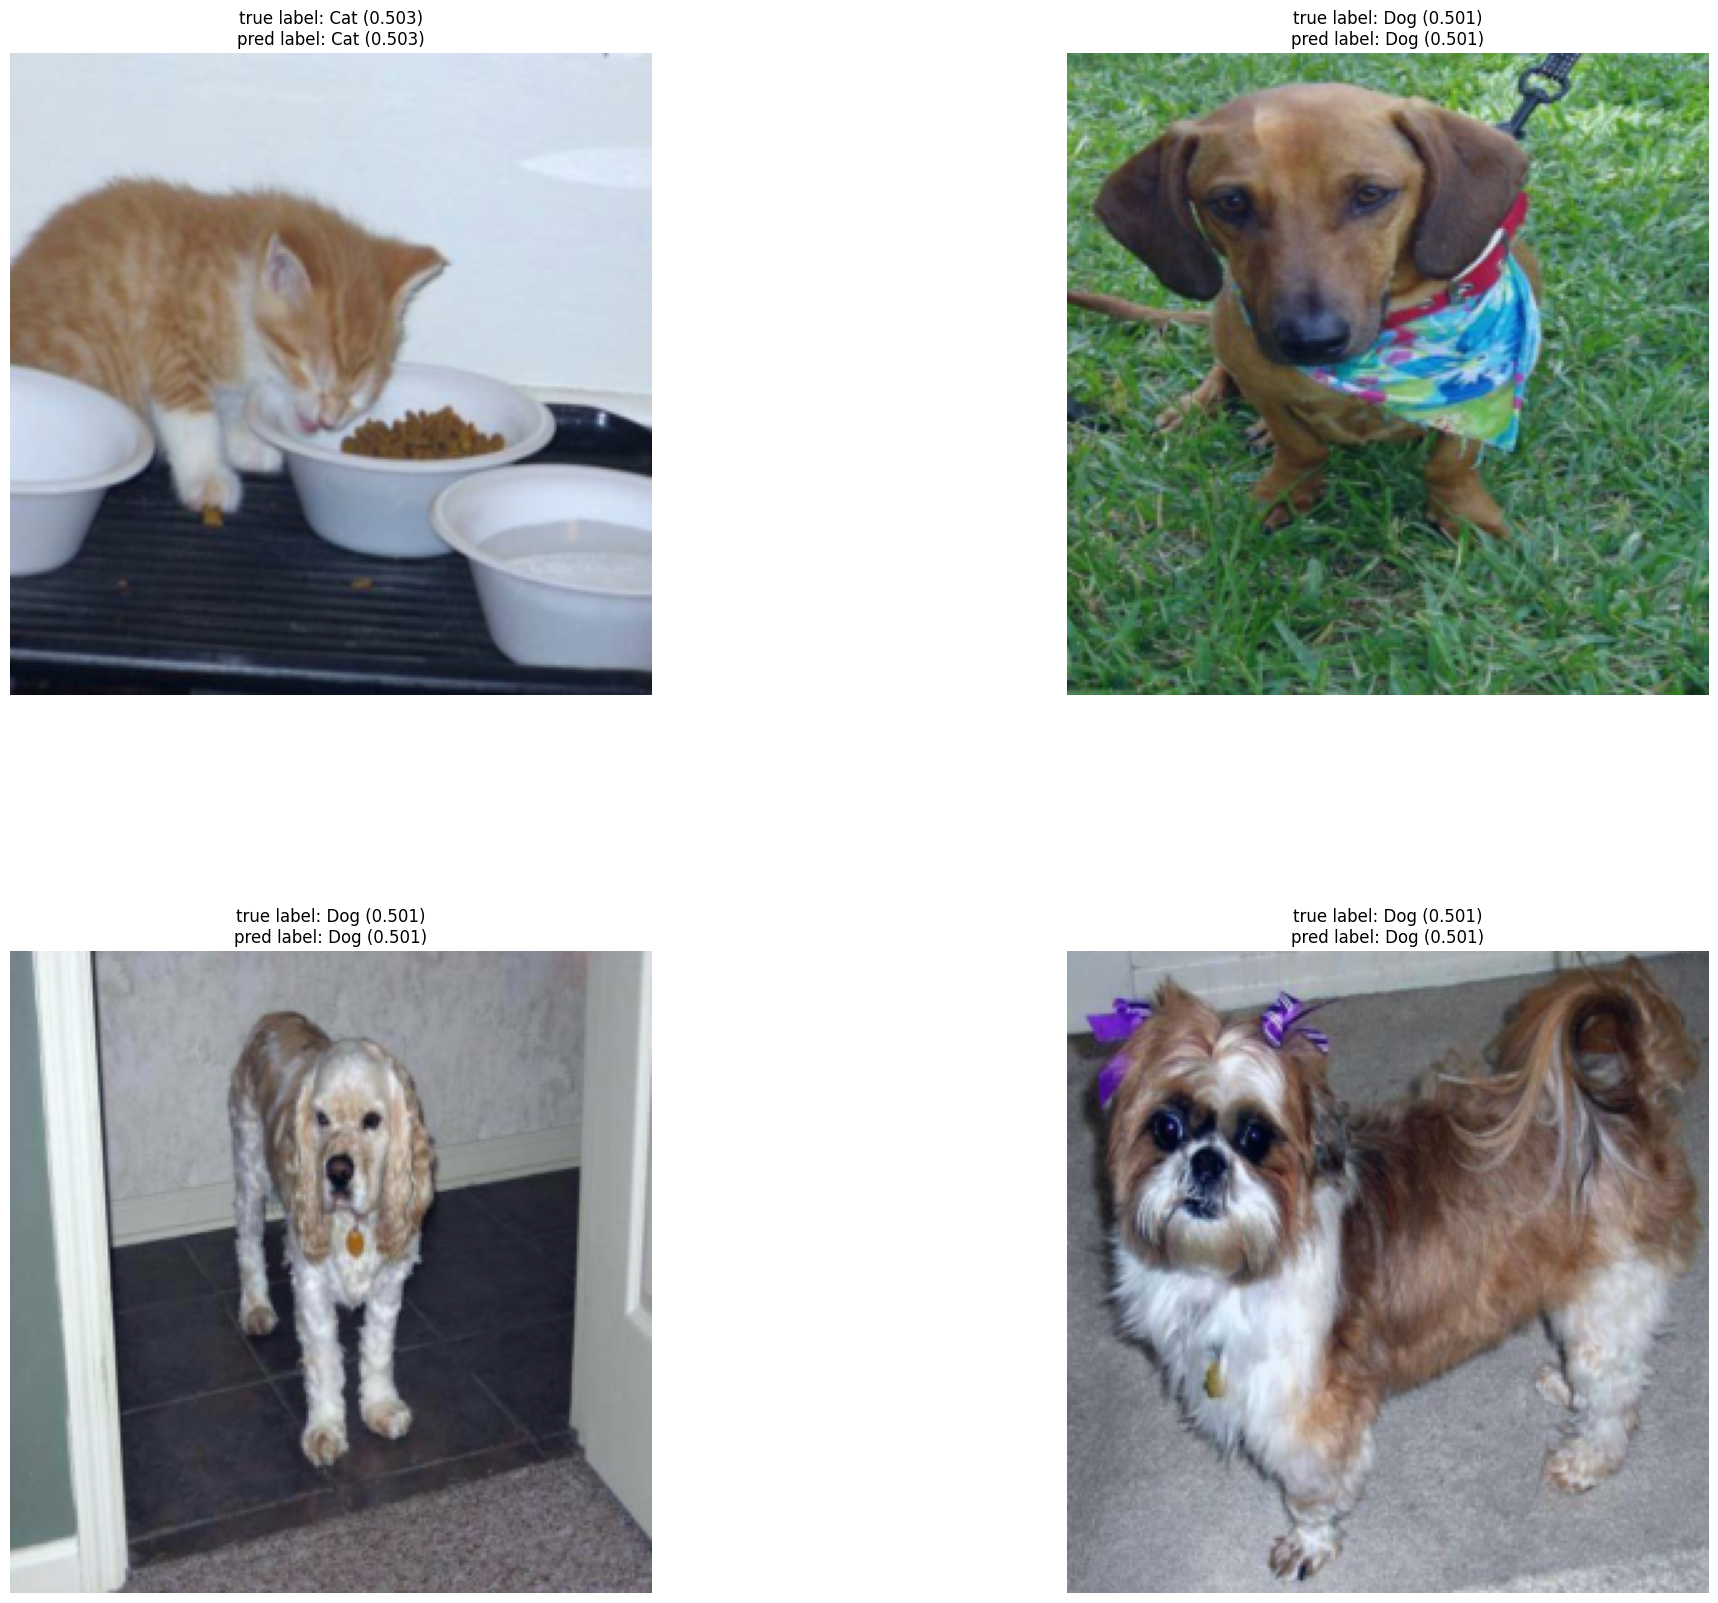

In [27]:
# 코드 6-64 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)